In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,StackingClassifier ,IsolationForest,  AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,cohen_kappa_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance


In [2]:
df = pd.read_csv("Debernardi et al 2020 data.csv")
df.shape

(590, 14)

In [3]:
df.head()


,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [4]:
df.describe




<bound method NDFrame.describe of     sample_id patient_cohort sample_origin  age sex  diagnosis stage  \
0          S1        Cohort1          BPTB   33   F          1   NaN   
1         S10        Cohort1          BPTB   81   F          1   NaN   
2        S100        Cohort2          BPTB   51   M          1   NaN   
3        S101        Cohort2          BPTB   61   M          1   NaN   
4        S102        Cohort2          BPTB   62   M          1   NaN   
..        ...            ...           ...  ...  ..        ...   ...   
585      S549        Cohort2          BPTB   68   M          3    IV   
586      S558        Cohort2          BPTB   71   F          3    IV   
587      S560        Cohort2          BPTB   63   M          3    IV   
588      S583        Cohort2          BPTB   75   F          3    IV   
589      S590        Cohort1          BPTB   74   M          3    IV   

    benign_sample_diagnosis  plasma_CA19_9  creatinine     LYVE1       REG1B  \
0                    

In [5]:
columns_ = df.columns.to_list()

df = df [["stage",
          "creatinine",
           "plasma_CA19_9",
          "age",
          "sex",
          "LYVE1",
          "REG1B",
          "TFF1",
          "REG1A",
          "diagnosis"]].copy()
df.sex =df.sex.map({"M":1 , "F": 0})
df.head()

,stage,creatinine,plasma_CA19_9,age,sex,LYVE1,REG1B,TFF1,REG1A,diagnosis
0,NaN,1.83222,11.7,33,0,0.893219,52.94884,654.282174,1262.000,1
1,NaN,0.97266,NaN,81,0,2.037585,94.46703,209.488250,228.407,1
2,NaN,0.78039,7.0,51,1,0.145589,102.36600,461.141000,NaN,1
3,NaN,0.70122,8.0,61,1,0.002805,60.57900,142.950000,NaN,1
4,NaN,0.21489,9.0,62,1,0.000860,65.54000,41.088000,NaN,1


In [6]:
df.isna().sum()


stage            391
creatinine         0
plasma_CA19_9    240
age                0
sex                0
LYVE1              0
REG1B              0
TFF1               0
REG1A            284
diagnosis          0
dtype: int64

In [7]:
#encoding
df['stage'] = df['stage'].fillna('Unknown')

# Step 2: Map the values
df['stage'] = df['stage'].map({
    'I': 1,
    'IA': 1,
    'IB': 1,
    'II': 2,
    'IIA': 2,
    'IIB': 2,
    'III': 3,
    'IV': 4,
    'Unknown': 0  
})


df['stage'] = df['stage'].astype(int)
print(df['stage'].unique())

[0 1 2 3 4]


In [8]:

from tabulate import tabulate

# List of feature columns
features = ['stage', 'creatinine', 'plasma_CA19_9', 'age', 'sex', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']

# Group by diagnosis type
grouped = df.groupby('diagnosis')

# Calculate min, max, and mean for each feature within each diagnosis category
stats = grouped[features].agg(['min', 'max', 'mean'])

# Flatten MultiIndex columns
stats.columns = ['_'.join(col).strip() for col in stats.columns.values]

# Reset index to turn 'diagnosis' back into a column
stats = stats.reset_index()

# Set 'diagnosis' as index to prepare for transpose
stats = stats.set_index('diagnosis')

# Transpose rows and columns
stats_t = stats.transpose()

# To make the output clearer, optionally reset index or rename columns
# For display, you might want to set 'diagnosis' as the header row
# and have features as rows, stats as columns

# Print the transposed table
print(tabulate(stats_t, headers='keys', tablefmt='grid'))

+--------------------+---------------+---------------+----------------+
|                    |             1 |             2 |              3 |
+====================+===============+===============+================+
| stage_min          |    0          |    0          |     1          |
+--------------------+---------------+---------------+----------------+
| stage_max          |    0          |    0          |     4          |
+--------------------+---------------+---------------+----------------+
| stage_mean         |    0          |    0          |     2.51256    |
+--------------------+---------------+---------------+----------------+
| creatinine_min     |    0.06786    |    0.05655    |     0.07917    |
+--------------------+---------------+---------------+----------------+
| creatinine_max     |    3.44955    |    3.33645    |     4.11684    |
+--------------------+---------------+---------------+----------------+
| creatinine_mean    |    0.797633   |    0.847929   |     0.916

In [9]:
mean_plasma_diagnosis_1 = df.loc[df['diagnosis'] == 1, 'plasma_CA19_9'].mean()
mean_plasma_diagnosis_2 = df.loc[df['diagnosis'] == 2, 'plasma_CA19_9'].mean()
mean_plasma_diagnosis_3 =df.loc[df["diagnosis"]== 3, 'plasma_CA19_9'].mean()
df.loc[(df['diagnosis'] == 1) & (df['plasma_CA19_9'].isna()), 'plasma_CA19_9'] = mean_plasma_diagnosis_1
df.loc[(df['diagnosis'] == 2) & (df['plasma_CA19_9'].isna()), 'plasma_CA19_9'] = mean_plasma_diagnosis_2
df.loc[(df['diagnosis'] == 3) & (df['plasma_CA19_9'].isna()), 'plasma_CA19_9'] = mean_plasma_diagnosis_3
mean_reg1a_diagnosis_1 = df.loc[df['diagnosis'] == 1, 'REG1A'].mean()
mean_reg1a_diagnosis_2 = df.loc[df['diagnosis'] == 2, 'REG1A'].mean()
mean_reg1a_diagnosis_3 =df.loc[df["diagnosis"]== 3, 'REG1A'].mean()
df.loc[(df['diagnosis'] == 1) & (df['REG1A'].isna()), 'REG1A'] = mean_reg1a_diagnosis_1
df.loc[(df['diagnosis'] == 2) & (df['REG1A'].isna()), 'REG1A'] = mean_reg1a_diagnosis_2
df.loc[(df['diagnosis'] == 3) & (df['REG1A'].isna()), 'REG1A'] = mean_reg1a_diagnosis_3

In [10]:
diagnosis = df.groupby("diagnosis").mean()
diagnosis.style.highlight_max()
df.isna().sum()

stage            0
creatinine       0
plasma_CA19_9    0
age              0
sex              0
LYVE1            0
REG1B            0
TFF1             0
REG1A            0
diagnosis        0
dtype: int64

In [11]:
df.describe
df.age

0      33
1      81
2      51
3      61
4      62
       ..
585    68
586    71
587    63
588    75
589    74
Name: age, Length: 590, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
#X , y
X = df.drop("diagnosis", axis =1)
y = df["diagnosis"]
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.dtypes)

stage              int32
creatinine       float64
plasma_CA19_9    float64
age                int64
sex                int64
LYVE1            float64
REG1B            float64
TFF1             float64
REG1A            float64
dtype: object


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
def evaluate_feature_subset(feature_mask):
    # Ensure at least one feature is selected
    if np.count_nonzero(feature_mask) == 0:
        return 1.0  # Worst score
    
    X_selected = X.loc[:, feature_mask == 1]
    classifier = DecisionTreeClassifier()
    scores = cross_val_score(classifier, X_selected, y, cv=5)
    return 1 - scores.mean()  # Minimize error

In [14]:
def whale_optimization(X, y, n_agents=20, max_iter=50):
    dim = X.shape[1]
    # Initialize population: binary vectors
    population = np.random.randint(0, 2, (n_agents, dim))
    leader_score = float('inf')
    leader_position = None
    
    for t in range(max_iter):
        for i in range(n_agents):
            # Evaluate fitness
            fitness = evaluate_feature_subset(population[i])
            if fitness < leader_score:
                leader_score = fitness
                leader_position = population[i].copy()
        
        a = 2 - t * (2 / max_iter)  # linearly decreasing from 2 to 0
        
        for i in range(n_agents):
            r = np.random.rand()
            A = 2 * a * r - a
            C = 2 * r
            p = np.random.rand()
            D = np.abs(C * leader_position - population[i])
            if p < 0.5:
                # Encircling prey
                new_position = leader_position - A * D
            else:
                # Search for prey (random whale)
                rand_agent = population[np.random.randint(n_agents)]
                D_rand = np.abs(C * rand_agent - population[i])
                new_position = rand_agent - A * D_rand
            
            # Sigmoid transfer for binary decision
            sigmoid = lambda x: 1 / (1 + np.exp(-x))
            prob = sigmoid(new_position)
            population[i] = (np.random.rand(dim) < prob).astype(int)
    
    return leader_position, leader_score
# Run Whale Optimization
best_mask_woa, best_score_woa = whale_optimization(X, y)
print("WOA Best Features:", np.where(best_mask_woa == 1)[0])
print("WOA Best Score:", best_score_woa)

WOA Best Features: [0 2 4 8]
WOA Best Score: 0.08135593220338977


In [15]:

def bald_eagle_search(X, y, n_agents=20, max_iter=50):
    dim = X.shape[1]
    population = np.random.randint(0, 2, (n_agents, dim))
    leader_score = float('inf')
    leader_position = None
    
    for t in range(max_iter):
        # Evaluate fitness
        for i in range(n_agents):
            fitness = evaluate_feature_subset(population[i])
            if fitness < leader_score:
                leader_score = fitness
                leader_position = population[i].copy()
        
        # Define search parameters (these can be tuned)
        for i in range(n_agents):
            # Update agents towards the leader
            new_position = population[i] + np.random.uniform(-0.1, 0.1, dim) * (leader_position - population[i])
            # Sigmoid transfer
            sigmoid = lambda x: 1 / (1 + np.exp(-x))
            prob = sigmoid(new_position)
            population[i] = (np.random.rand(dim) < prob).astype(int)
    
    return leader_position, leader_score
# Run Bald Eagle Search
best_mask_bes, best_score_bes = bald_eagle_search(X, y)
print("BES Best Features:", np.where(best_mask_bes == 1)[0])
print("BES Best Score:", best_score_bes)

BES Best Features: [0 2 4 8]
BES Best Score: 0.08135593220338977


In [16]:
  
# Define the Sea Lion Optimization function
def sea_lion_optimization(X, y, n_agents=20, max_iter=50):
    dim = X.shape[1]
    population = np.random.randint(0, 2, (n_agents, dim))
    leader_score = float('inf')
    leader_position = None
    
    for t in range(max_iter):
        # Evaluate fitness
        for i in range(n_agents):
            fitness = evaluate_feature_subset(population[i])
            if fitness < leader_score:
                leader_score = fitness
                leader_position = population[i].copy()
        
        # Movement towards leader with some randomness
        for i in range(n_agents):
            new_position = population[i] + np.random.uniform(-0.2, 0.2, dim) * (leader_position - population[i])
            # Sigmoid transfer
            sigmoid = lambda x: 1 / (1 + np.exp(-x))
            prob = sigmoid(new_position)
            population[i] = (np.random.rand(dim) < prob).astype(int)
    
    return leader_position, leader_score
    
# Call the function
best_mask_slo, best_score_slo = sea_lion_optimization(X, y)

print("SLO Best Features:", np.where(best_mask_slo == 1)[0])
print("SLO Best Score:", best_score_slo)

SLO Best Features: [0 2 4 8]
SLO Best Score: 0.0796610169491524


In [ ]:

def evaluate_feature_subset(feature_mask):
    pass

def pso_feature_selection(X, y, n_particles=20, max_iter=50, w=0.7, c1=1.5, c2=1.5):
    dim = X.shape[1]
    
    # Initialize particles randomly (binary positions)
    particles_position = np.random.randint(0, 2, (n_particles, dim))
    # Initialize velocities
    velocities = np.random.uniform(-1, 1, (n_particles, dim))
    
    # Initialize personal best positions and scores
    pbest_position = particles_position.copy()
    pbest_score = [np.inf] * n_particles
    
    # Initialize global best
    gbest_position = None
    gbest_score = float('inf')

    for t in range(max_iter):
        for i in range(n_particles):
    fitness = evaluate_feature_subset(particles_position[i])
    pbest_score[i] = fitness
     # Update personal best if current is better
    if fitness < pbest_score[i]:
    pbest_score[i] = fitness
    pbest_position[i] = particles_position[i].copy()
     # Update global best if current is better
    if fitness < gbest_score:
    gbest_score = fitness
    gbest_position = particles_position[i].copy()
        
     # Update velocities and positions
    r1 = np.random.rand(n_particles, dim)
    r2 = np.random.rand(n_particles, dim)
    velocities = (
            w * velocities
            + c1 * r1 * (pbest_position - particles_position)
            + c2 * r2 * (gbest_position - particles_position)
        )
    # Sigmoid transfer function for binary position update
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    prob = sigmoid(velocities)
    # Update positions based on probabilities
    random_vals = np.random.rand(n_particles, dim)
    particles_position = (random_vals < prob).astype(int)
    
return gbest_position, gbest_score

# Call the function
best_mask_pso, best_score_pso = pso_feature_selection(X, y)

print("PSO Best Features:", np.where(best_mask_pso == 1)[0])
print("PSO Best Score:", best_score_pso)


In [ ]:
# Run Whale Optimization
best_mask_woa, best_score_woa = whale_optimization(X, y)
print("WOA Best Features:", np.where(best_mask_woa == 1)[0])
print("WOA Best Score:", best_score_woa)

# Run Bald Eagle Search
best_mask_bes, best_score_bes = bald_eagle_search(X, y)
print("BES Best Features:", np.where(best_mask_bes == 1)[0])
print("BES Best Score:", best_score_bes)

# Run Sea Lion Optimization
best_mask_slo, best_score_slo = sea_lion_optimization(X, y)
print("SLO Best Features:", np.where(best_mask_slo == 1)[0])
print("SLO Best Score:", best_score_slo)

In [55]:
# Train XGBoost model
xgb_model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_fs, y_train)
    
# Train LightGBM model
lgb_model = lgb.LGBMClassifier(**lgb_best_params, random_state=42)
lgb_model.fit(X_train_fs, y_train)
    
# Predictions
xgb_pred = xgb_model.predict(X_test_fs)
lgb_pred = lgb_model.predict(X_test_fs)

NameError: name 'X_train_fs' is not defined

In [39]:
print(xgb_best_params)

{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'use_label_encoder': False, 'eval_metric': 'logloss'}


In [40]:
# Remove duplicate parameters if present
params = xgb_best_params.copy()

# Remove these keys if they exist
params.pop('use_label_encoder', None)
params.pop('eval_metric', None)

xgb_model = XGBClassifier(**params, random_state=42)

In [42]:
    # Train XGBoost model
    xgb_model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train_fs, y_train)
    
    # Train LightGBM model
    lgb_model = lgb.LGBMClassifier(**lgb_best_params, random_state=42)
    lgb_model.fit(X_train_fs, y_train)
    
    # Predictions
    xgb_pred = xgb_model.predict(X_test_fs)
    lgb_pred = lgb_model.predict(X_test_fs)
    

# ============================
# 4. Ensemble Voting
# ============================

def ensemble_voting(xgb_pred, lgb_pred):
    # Hard voting (mode)
    ensemble_pred = mode(np.vstack((xgb_pred, lgb_pred)), axis=0)[0].flatten()
    return ensemble_pred

def ensemble_soft_voting(xgb_proba, lgb_proba):
    # Soft voting (average probabilities)
    ensemble_proba = (xgb_proba + lgb_proba) / 2
    ensemble_pred = np.argmax(ensemble_proba, axis=1)
    return ensemble_pred

# ============================
# 5. Main Evaluation Workflow
# ============================

# Evaluate for each feature set
xgb_model_woa, lgb_model_woa, xgb_pred_woa, lgb_pred_woa = evaluate_models_on_features(woa_features, "WOA")
xgb_model_bes, lgb_model_bes, xgb_pred_bes, lgb_pred_bes = evaluate_models_on_features(bes_features, "BES")
xgb_model_slo, lgb_model_slo, xgb_pred_slo, lgb_pred_slo = evaluate_models_on_features(slo_features, "SLO")

# ============================
# 6. Ensemble Predictions and Evaluation
# ============================

# --- Hard Voting Ensemble ---
ensemble_preds_woa = ensemble_voting(xgb_pred_woa, lgb_pred_woa)
ensemble_preds_bes = ensemble_voting(xgb_pred_bes, lgb_pred_bes)
ensemble_preds_slo = ensemble_voting(xgb_pred_slo, lgb_pred_slo)

# Evaluate ensemble with hard voting
print("\n=== Ensemble (Hard Voting) Performance ===")
evaluate_model(y_test, ensemble_preds_woa, "Ensemble WOA")
evaluate_model(y_test, ensemble_preds_bes, "Ensemble BES")
evaluate_model(y_test, ensemble_preds_slo, "Ensemble SLO")

# --- Soft Voting Ensemble ---
# Obtain probability predictions
xgb_proba_woa = xgb_model_woa.predict_proba(X_test[woa_features])
lgb_proba_woa = lgb_model_woa.predict_proba(X_test[woa_features])

xgb_proba_bes = xgb_model_bes.predict_proba(X_test[bes_features])
lgb_proba_bes = lgb_model_bes.predict_proba(X_test[bes_features])

xgb_proba_slo = xgb_model_slo.predict_proba(X_test[slo_features])
lgb_proba_slo = lgb_model_slo.predict_proba(X_test[slo_features])

# Compute soft ensemble predictions
ensemble_pred_woa = ensemble_soft_voting(xgb_proba_woa, lgb_proba_woa)
ensemble_pred_bes = ensemble_soft_voting(xgb_proba_bes, lgb_proba_bes)
ensemble_pred_slo = ensemble_soft_voting(xgb_proba_slo, lgb_proba_slo)

# Evaluate soft voting ensemble
print("\n=== Ensemble (Soft Voting) Performance ===")
evaluate_model(y_test, ensemble_pred_woa, "Ensemble WOA")
evaluate_model(y_test, ensemble_pred_bes, "Ensemble BES")
evaluate_model(y_test, ensemble_pred_slo, "Ensemble SLO")

# ============================
# 7. SHAP Evaluation (Placeholder)
# ============================

# Note: The SHAP evaluation involves computing SHAP values for the best models
# and visualizing feature importance.
# Example (assuming shap and visualization setup):
# import shap
# explainer_xgb = shap.TreeExplainer(xgb_model_woa)
# shap_values = explainer_xgb.shap_values(X_test[selected_feature_names])
# shap.summary_plot(shap_values, X_test[selected_feature_names])

# Summary:
# - The code evaluates models based on the optimal features selected by MHAs.
# - Hyperparameters are used for training the classifiers.
# - Both hard and soft ensemble methods are demonstrated.
# - SHAP analysis can further elucidate feature impacts.



Unique classes in y_train: [1 2 3]


In [24]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import lightgbm as lgb
from scipy.stats import mode
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score

#entrance data
from sklearn.model_selection import train_test_split
#X , y
X = df_cleaned.drop("diagnosis", axis =1)
y = df_cleaned["diagnosis"]
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. MHAs and Hyperparameter Output

# Define feature sets selected by MHAs
woa_features = np.array([0 ,1 ,2 ,4, 5 ,8])  # WOA optimal features
bes_features = np.array([0, 2, 4 ,6 ,8])  # BES optimal features
slo_features = np.array([0 ,1 ,2 ,4, 6 ,8])     # SLO optimal features

# Map feature indices to feature names
feature_names = X.columns.tolist()

# Example hyperparameters (replace with your actual optimal hyperparameters)
xgb_best_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

lgb_best_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# 2. Define Evaluation Function

def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")
    print("-" * 30)

# ============================
# 3. Function to Evaluate Models on Selected Features
# ============================

def evaluate_models_on_features(selected_feature_indices, method_name):
    selected_feature_names = [feature_names[i] for i in selected_feature_indices]
    print(f"\n=== Evaluation for {method_name} Features: {selected_feature_names} ===")
    
    # Ensure y_train and y_test are properly initialized
    global y_train, y_test, X_train, X_test
    
    # Check if y_train needs relabeling
    if np.array_equal(np.unique(y_train), [1, 2, 3]):
        y_train = y_train - 1  # convert labels from [1,2,3] to [0,1,2]
        y_test = y_test - 1
    
    # Subset features
    X_train_fs = X_train.iloc[:, selected_feature_indices]
    X_test_fs = X_test.iloc[:, selected_feature_indices]
    
    # --- Train and evaluate XGBClassifier ---
    xgb_model = XGBClassifier(**xgb_best_params, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train_fs, y_train)
    y_pred_xgb = xgb_model.predict(X_test_fs)
    evaluate_model(y_test, y_pred_xgb, "XGBoost")
    
    # --- Train and evaluate LightGBM ---
    lgb_model = lgb.LGBMClassifier(**lgb_best_params)
    lgb_model.fit(X_train_fs, y_train)
    y_pred_lgb = lgb_model.predict(X_test_fs)
    evaluate_model(y_test, y_pred_lgb, "LightGBM")


Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\Surface\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:12:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Surface\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:12:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Surface\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:12:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Surface\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:12:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Info] Number of positive: 266, number of negative: 267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 533, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499062 -> initscore=-0.003752
[LightGBM] [Info] Start training from score -0.003752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\Surface\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\Surface\AppData\Local\Temp\ipykernel_15404\192564791.py:89: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test)


SHAP Summary Plot for XGBoost


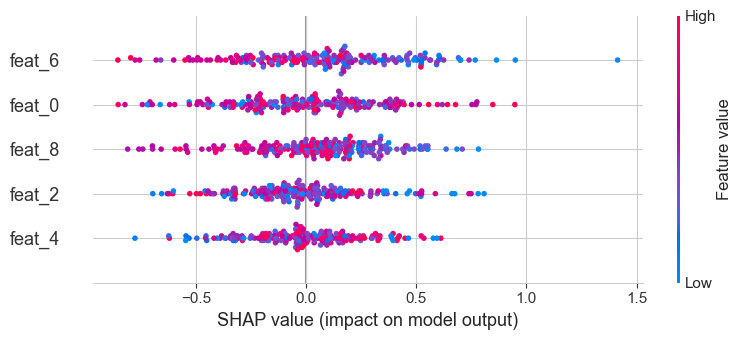

SHAP Summary Plot for LightGBM


C:\Users\Surface\AppData\Local\Temp\ipykernel_15404\192564791.py:92: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_lgb, X_test)


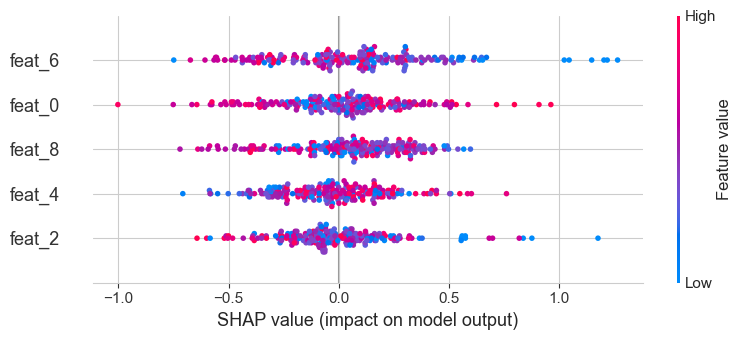

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score
from xgboost import XGBClassifier
import lightgbm as lgb
import shap

# Assume your dataset is loaded into features (X) and labels (y)
# For illustration, let's create dummy data
np.random.seed(42)
num_samples = 1000
num_total_features = 10

X = pd.DataFrame(np.random.randn(num_samples, num_total_features), columns=[f'feat_{i}' for i in range(num_total_features)])
y = np.random.randint(0, 2, size=num_samples)

# 1. Define selected features based on MHAs and hyperparameter output
woa_features = np.array([0, 2, 4, 6, 8])  # Adjusted as per your description
selected_features = [f'feat_{i}' for i in woa_features]

X_selected = X[selected_features]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# 2. Hyperparameter tuning for XGBClassifier
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='f1', cv=3, verbose=1)
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_

# Hyperparameter tuning for LightGBM
lgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

lgbm = lgb.LGBMClassifier(random_state=42)
lgbm_grid = GridSearchCV(lgbm, param_grid=lgb_param_grid, scoring='f1', cv=3, verbose=1)
lgbm_grid.fit(X_train, y_train)

best_lgbm = lgbm_grid.best_estimator_

# 3. Model predictions
xgb_preds = best_xgb.predict(X_test)
lgbm_preds = best_lgbm.predict(X_test)

# 4. Performance evaluation
from sklearn.metrics import f1_score, accuracy_score, recall_score, cohen_kappa_score

models = {
    'XGBoost': (xgb_preds, best_xgb),
    'LightGBM': (lgbm_preds, best_lgbm)
}

for model_name, (preds, model) in models.items():
    print(f"Performance metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_test, preds):.3f}")
    print(f"F1 Score: {f1_score(y_test, preds):.3f}")
    print(f"Recall: {recall_score(y_test, preds):.3f}")
    print(f"Kappa: {cohen_kappa_score(y_test, preds):.3f}")
    print(classification_report(y_test, preds))
    print("-" * 50)

# 5. SHAP Analysis for interpretability
# For XGBoost
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# For LightGBM
explainer_lgb = shap.TreeExplainer(best_lgbm)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Plot SHAP summary plots
print("SHAP Summary Plot for XGBoost")
shap.summary_plot(shap_values_xgb, X_test)

print("SHAP Summary Plot for LightGBM")
shap.summary_plot(shap_values_lgb, X_test)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\Surface\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [14:28:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[LightGBM] [Info] Number of positive: 402, number of negative: 398
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502500 -> initscore=0.010000
[LightGBM] [Info] Start training from score 0.010000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\Surface\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\Surface\AppData\Local\Temp\ipykernel_15404\1585940480.py:141: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test)


SHAP Summary Plot for XGBoost


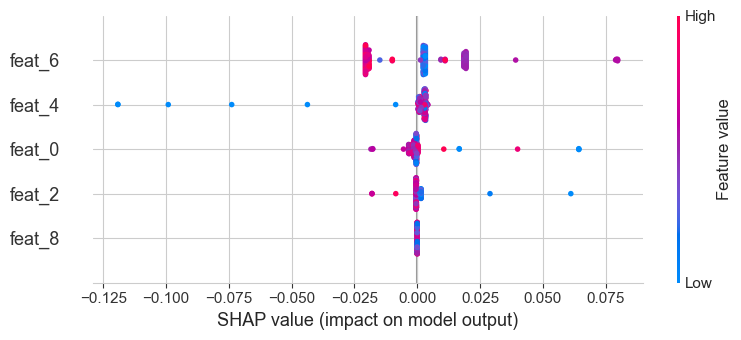

SHAP Summary Plot for LightGBM


C:\Users\Surface\AppData\Local\Temp\ipykernel_15404\1585940480.py:144: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_lgb, X_test)


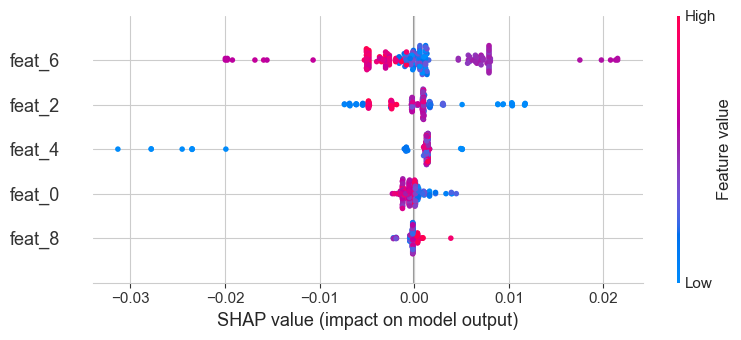

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, make_scorer
from xgboost import XGBClassifier
import lightgbm as lgb
import shap

# Assume your dataset is loaded into features (X) and labels (y)
# For illustration, let's create dummy data
np.random.seed(42)
num_samples = 1000
num_total_features = 10

X = pd.DataFrame(np.random.randn(num_samples, num_total_features), columns=[f'feat_{i}' for i in range(num_total_features)])
y = np.random.randint(0, 2, size=num_samples)

# 1. Define selected features based on MHAs and hyperparameter output
woa_features = np.array([0, 2, 4, 6, 8])  # Adjust as needed
selected_features = [f'feat_{i}' for i in woa_features]

X_selected = X[selected_features]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred)),
    'recall': make_scorer(lambda y_true, y_pred: recall_score(y_true, y_pred)),
    'kappa': make_scorer(lambda y_true, y_pred: cohen_kappa_score(y_true, y_pred))
}

# 2. Hyperparameter tuning for XGBClassifier using GridSearchCV with cross-validation
xgb_param_grid = {
    'n_estimators': [ 100,200,300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001,0.01, 0.1],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    scoring='f1',  # Primary metric for tuning
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1
)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

# Hyperparameter tuning for LightGBM
lgb_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001,0.01, 0.1],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1]
}

lgbm = lgb.LGBMClassifier(random_state=42)

lgbm_grid = GridSearchCV(
    estimator=lgbm,
    param_grid=lgb_param_grid,
    scoring='f1',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1
)
lgbm_grid.fit(X_train, y_train)
best_lgbm = lgbm_grid.best_estimator_

# 3. Evaluate models with cross-validation to get metrics across folds
def evaluate_model(model, X, y, cv_strategy):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv_strategy,
        scoring=scoring_metrics,
        n_jobs=-1,
        return_train_score=False
    )
    # Compute mean and std for each metric
    results = {metric: (np.mean(scores), np.std(scores)) for metric, scores in cv_results.items() if metric.startswith(('test_', 'train_'))}
    return results

print("Cross-validation performance for XGBoost:")
xgb_cv_results = evaluate_model(best_xgb, X_selected, y, cv_strategy)
for metric, (mean_score, std_score) in xgb_cv_results.items():
    print(f"{metric}: {mean_score:.3f} ± {std_score:.3f}")

print("\nCross-validation performance for LightGBM:")
lgbm_cv_results = evaluate_model(best_lgbm, X_selected, y, cv_strategy)
for metric, (mean_score, std_score) in lgbm_cv_results.items():
    print(f"{metric}: {mean_score:.3f} ± {std_score:.3f}")

# 4. Final evaluation on test set
from sklearn.metrics import f1_score, accuracy_score, recall_score, cohen_kappa_score, classification_report

# Predictions
xgb_preds = best_xgb.predict(X_test)
lgbm_preds = best_lgbm.predict(X_test)

# Function to print metrics
def print_metrics(y_true, preds, model_name):
    print(f"\nPerformance metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, preds):.3f}")
    print(f"F1 Score: {f1_score(y_true, preds):.3f}")
    print(f"Recall: {recall_score(y_true, preds):.3f}")
    print(f"Kappa: {cohen_kappa_score(y_true, preds):.3f}")
    print(classification_report(y_true, preds))

print_metrics(y_test, xgb_preds, "XGBoost")
print_metrics(y_test, lgbm_preds, "LightGBM")

# 5. SHAP interpretability (optional)
import shap

# For XGBoost
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# For LightGBM
explainer_lgb = shap.TreeExplainer(best_lgbm)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Plot SHAP summary plots
print("SHAP Summary Plot for XGBoost")
shap.summary_plot(shap_values_xgb, X_test)

print("SHAP Summary Plot for LightGBM")
shap.summary_plot(shap_values_lgb, X_test)
